## Imports

In [58]:
import xgboost as xgb
from xgboost import cv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean
from sklearn.metrics import accuracy_score
import joblib
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score
from sklearn.calibration import CalibratedClassifierCV
import scikitplot as skplt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
import random
import matplotlib.pyplot as plt

## Read and Split Data

In [59]:
data = pd.read_csv("baseline_processed.csv")

In [60]:
alive_index_icu = []
alive_index_hosp = []

dead_index_icu = []
dead_index_hosp = []

In [61]:
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [62]:
alive_index_icu = []
alive_index_hosp = []

dead_index_icu = []
dead_index_hosp = []

In [63]:
# train = train.drop(columns = "index")
train = train.reset_index()
train = train.drop(columns = "index")
for index, row in train.iterrows():
    if row['label_icu'] == 0:
        alive_index_icu.append(index)
    else:
        dead_index_icu.append(index)

    if row['label_hosp'] == 0:
        alive_index_hosp.append(index)
    else:
        dead_index_hosp.append(index)
    

In [64]:
print(len(alive_index_hosp))
print(len(dead_index_hosp))

4144
882


In [65]:


alive_sample = random.choices(alive_index_hosp, k = len(dead_index_hosp))
dead_sample = dead_index_hosp
print(len(alive_sample))
print(len(dead_sample))

882
882


In [66]:
train["alive_24"] = np.where(((train['icu_timestep_back'] <= 48) & (train['icu_timestep_back'] > 24)& (train['label_icu'] == 0)), 1, 0)
train["die_24"] = np.where(((train['icu_timestep_back'] <= 48) & (train['icu_timestep_back'] > 24) & (train['label_icu'] == 1)), 1, 0)
test["alive_24"] = np.where(((test['icu_timestep_back'] <= 48) & (test['icu_timestep_back'] > 24) & (test['label_icu'] == 0)), 1, 0)
test["die_24"] = np.where(((test['icu_timestep_back'] <= 48) & (test['icu_timestep_back'] > 24) & (test['label_icu'] == 1)), 1, 0)

data["alive_24"] = np.where(((data['icu_timestep_back'] <= 48) & (data['icu_timestep_back'] > 24) & (data['label_icu'] == 0)), 1, 0)
data["die_24"] = np.where(((data['icu_timestep_back'] <= 48) & (data['icu_timestep_back'] > 24) & (data['label_icu'] == 1)), 1, 0)

In [67]:
train

,stay_id,label_hosp,label_icu,icu_timestep_back,hosp_timestep_back,Age,gender,insurance,race,admission_type,...,sodium_min,sodium_max,potassium_min,potassium_max,dialysis_present,SOFA,urineoutput,weight,alive_24,die_24
0,31704775,0,0,73,96,67,1,3,4,6,...,134,135,3.7,3.8,0,5,1540.0,119.7,0,0
1,31851162,0,0,66,284,36,1,2,4,6,...,137,137,4.1,4.1,0,0,2625.0,80.2,0,0
2,36894788,0,0,74,100,57,0,2,4,6,...,140,143,3.7,3.8,0,1,1350.0,74.0,0,0
3,38935908,0,0,54,465,63,0,2,4,6,...,136,138,3.1,4.2,0,9,925.0,79.0,0,0
4,39789149,0,0,186,185,57,0,6,3,6,...,143,144,3.8,3.9,0,6,1295.0,72.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,38306089,0,0,60,128,70,1,3,4,6,...,142,145,3.7,4.4,0,5,2185.0,81.1,0,0
5022,37388614,0,0,46,185,78,1,3,4,6,...,140,142,4.3,4.4,0,2,1175.0,102.7,1,0
5023,32638611,0,0,41,87,79,0,3,4,7,...,127,131,3.0,4.3,0,4,1620.0,58.7,1,0
5024,38003553,0,0,146,285,80,1,3,4,9,...,143,143,4.5,4.5,0,6,100.0,90.7,0,0


In [68]:
# for index, row in train.iterrows():
#     if row['alive_24'] == 1:
#         print("ALIVE")

#     if row['die_24'] == 1:
#         print("DIE")
    

In [69]:
resample_train = train.iloc[alive_sample + dead_sample]
resample_train = resample_train.reset_index().drop(columns = "index")
# df.iloc[ind_list]
resample_train

,stay_id,label_hosp,label_icu,icu_timestep_back,hosp_timestep_back,Age,gender,insurance,race,admission_type,...,sodium_min,sodium_max,potassium_min,potassium_max,dialysis_present,SOFA,urineoutput,weight,alive_24,die_24
0,35072347,0,0,63,62,52,1,6,4,8,...,135,135,4.1,4.1,0,1,1885.0,70.50,0,0
1,38290791,0,0,44,91,78,1,3,4,7,...,136,139,3.5,3.9,0,5,2425.0,100.35,1,0
2,39525118,0,0,30,160,67,1,3,4,7,...,139,140,3.6,4.1,0,6,1585.0,84.00,1,0
3,34733777,0,0,22,74,26,0,6,4,6,...,136,140,3.7,3.7,0,3,2545.0,54.20,0,0
4,34597041,0,0,53,121,84,1,3,4,7,...,138,141,3.4,5.2,0,4,1165.0,61.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,30201704,1,0,36,64,63,0,6,4,9,...,133,136,3.3,3.6,0,9,525.0,85.20,1,0
1760,39863507,1,1,508,505,38,0,3,6,6,...,137,141,3.4,4.1,0,7,2885.0,47.00,0,0
1761,39524406,1,1,102,100,68,0,6,4,9,...,134,135,3.3,3.9,0,4,1097.0,61.50,0,0
1762,36047939,1,0,63,126,92,1,6,6,7,...,140,142,5.0,5.4,0,9,842.0,60.00,0,0


In [70]:
train_label_hosp = train['label_hosp']
train_label_icu = train['label_icu']
train_hosp_time = train["hosp_timestep_back"] / 747
train_icu_time = train["icu_timestep_back"] / 283

train_features = train.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24'])
#train_features['hosp_timestep_back'] = np.where(train_features['hosp_timestep_back'] == "female", 0, 1)
# dtrain = xgb.DMatrix(train_features, label=train_label_hosp)

In [71]:
test_label_hosp = test['label_hosp']
test_label_icu = test['label_icu']
test_hosp_time = test["hosp_timestep_back"] / 747
test_icu_time = test["icu_timestep_back"]/ 283
test_features = test.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24'])

# test_features = pd.get_dummies(test_features)
test_features = test_features[train_features.columns]
# dtest = xgb.DMatrix(test_features, label=test_label_hosp)

## Define function for xgboost training

In [72]:
model = xgb.XGBClassifier()
# model.fit(train_features, train_label_icu, eval_metric = "auc", verbose = 10)
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

## Train model combine

In [73]:
model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:logistic'))
print("========================== training & validation ==========================")
# k_fold_training(model, resample_train,["label_hosp", "label_icu", 'alive_24', 'die_24'], splits = 5, model_name = "classification_combine2.pkl")

# print(predictions)
Y = resample_train[['label_hosp', 'label_icu', 'alive_24', 'die_24']]
X = resample_train.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24']);
# print(Y)
# auc = cross_val_score(model, X, Y, scoring = "roc_auc", cv = 5)
# print(f"5 cross fold auc = {auc}")
model.fit(X, Y)
test_features = test.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24'])
predictions = model.predict(test_features)
descicion_icu = []

joblib.dump(model, 'model.pkl')

print("\n================================= testing =================================")
AUC_icu = roc_auc_score(test_label_icu, predictions[:, 1])
AUC_hosp = roc_auc_score(test_label_hosp, predictions[:, 0])
print( "AUC icu test: %.2f" % (AUC_icu))
print( "AUC hosp test: %.2f\n" % (AUC_hosp))

AUC_icu = roc_auc_score(test["alive_24"], predictions[:, 2])
AUCAUC_hosp = roc_auc_score(test["die_24"], predictions[:, 3])
print( "AUC alive test: %.2f" % (AUC_icu ))
print( "AUC die test: %.2f\n" % (AUC_hosp ))

========================== training & validation ==========================

================================= testing =================================
AUC icu test: 0.89
AUC hosp test: 0.85

AUC alive test: 0.62
AUC die test: 0.85



In [74]:
# for row in predictions:
#     if row[2] > 0.5:
#         print("ALIVE")

#     if row[3] > 0.5:
#         print("DIE")


In [75]:

# model = joblib.load('combine_final.pkl')
model = joblib.load('xgboost_model.pkl')

print("\n================================= testing =================================")
print( "Accuracy icu test: %.2f%%" % (accuracy_icu * 100.0))
print( "Accuracy hosp test: %.2f%%\n" % (accuracy_hosp * 100.0))
accuracy_icu = roc_auc_score(test_label_icu, predictions[:, 1])
accuracy_hosp = roc_auc_score(test_label_hosp, predictions[:, 0])
print( "AUC icu test: %.2f%%" % (accuracy_icu * 100.0))
print( "AUC hosp test: %.2f%%\n" % (accuracy_hosp * 100.0))


================================= testing =================================
Accuracy icu test: 88.85%
Accuracy hosp test: 84.43%

AUC icu test: 89.07%
AUC hosp test: 85.36%



In [76]:
print(len(test))
test, val = train_test_split(test, test_size=0.5, random_state=42, shuffle=True)

y_val_hosp = val['label_hosp']
y_val_icu = val['label_icu']
X_val = val.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24'])
predictions = model.predict(X_val)

1257


the optimal threshold is 0.41983067989349365


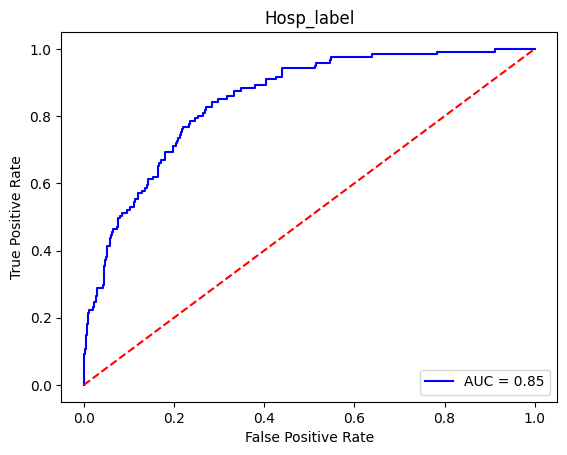

In [77]:
fpr, tpr, threshold = roc_curve(y_val_hosp, predictions[:,0])
roc_auc = auc(fpr, tpr)
plt.title('Hosp_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_hosp = threshold[optimal_idx]

# plt.show()
# plt.savefig("image/hosp_ROC.png")
print(f"the optimal threshold is {optimal_threshold_hosp}")

the optimal threshold is 0.06065775826573372


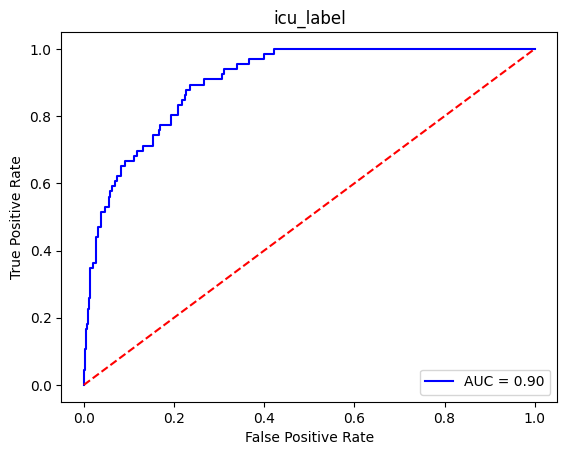

In [78]:
fpr, tpr, threshold = roc_curve(y_val_icu, predictions[:,1])
roc_auc = auc(fpr, tpr)
plt.title('icu_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_icu = threshold[optimal_idx]

# plt.show()
# plt.savefig("image/icu_ROC.png")
print(f"the optimal threshold is {optimal_threshold_icu}")

the optimal threshold is 0.022670552134513855


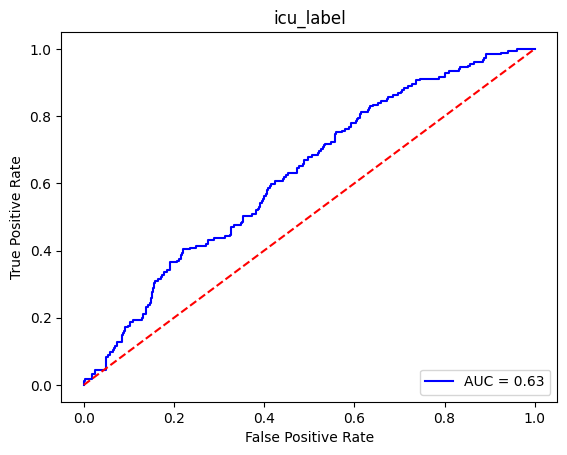

In [79]:
fpr, tpr, threshold = roc_curve(val['alive_24'], predictions[:,2])
roc_auc = auc(fpr, tpr)
plt.title('icu_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_alive = threshold[optimal_idx]

# plt.show()
# plt.savefig("image/icu_ROC.png")
print(f"the optimal threshold is {optimal_threshold_alive}")

the optimal threshold is 0.0015480585861951113


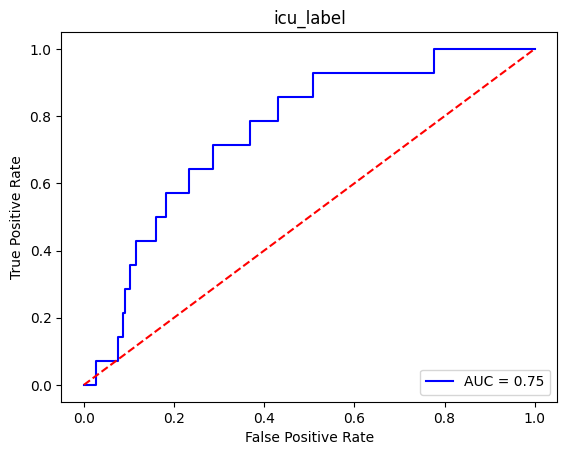

In [80]:
fpr, tpr, threshold = roc_curve(val['die_24'], predictions[:,3])
roc_auc = auc(fpr, tpr)
plt.title('icu_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_die = threshold[optimal_idx]

# plt.show()
# plt.savefig("image/icu_ROC.png")
print(f"the optimal threshold is {optimal_threshold_die}")

## ROC curve

In [81]:
test_label_hosp = test['label_hosp']
test_label_icu = test['label_icu']
test_features = test.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24'])
predictions = model.predict(test_features)

In [82]:
val['stay_id'].to_csv("val.csv", index = False)

In [83]:
test['stay_id'].to_csv("test.csv", index = False)

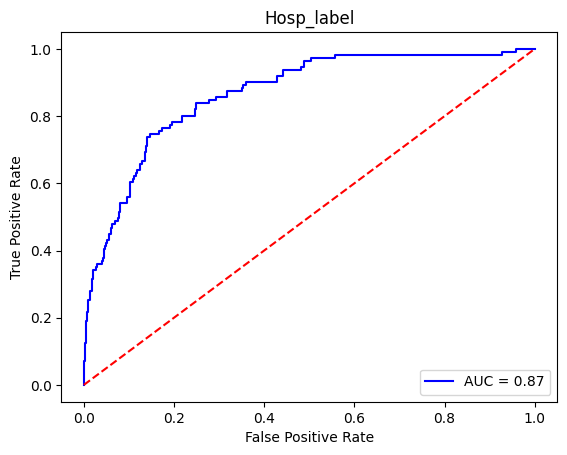

In [86]:

fpr, tpr, threshold = roc_curve(test_label_hosp, predictions[:,0])
roc_auc = auc(fpr, tpr)
plt.title('Hosp_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold_hosp = threshold[optimal_idx]

# plt.show()
plt.savefig("image/hosp_ROC.png")
# print(f"the optimal threshold is {optimal_threshold_hosp}")

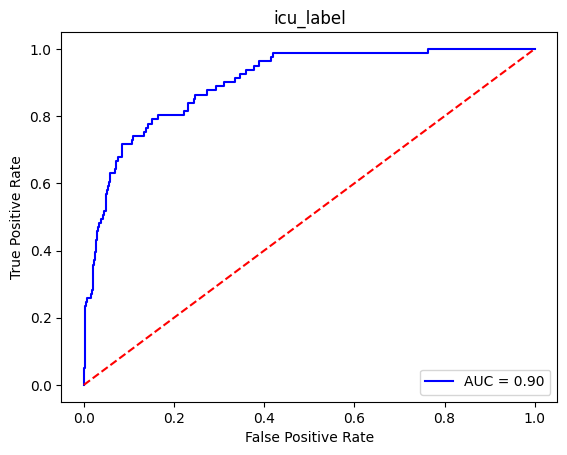

In [87]:
fpr, tpr, threshold = roc_curve(test_label_icu, predictions[:,1])
roc_auc = auc(fpr, tpr)
plt.title('icu_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold_icu = threshold[optimal_idx]

# plt.show()
plt.savefig("image/icu_ROC.png")
# print(f"the optimal threshold is {optimal_threshold_icu}")

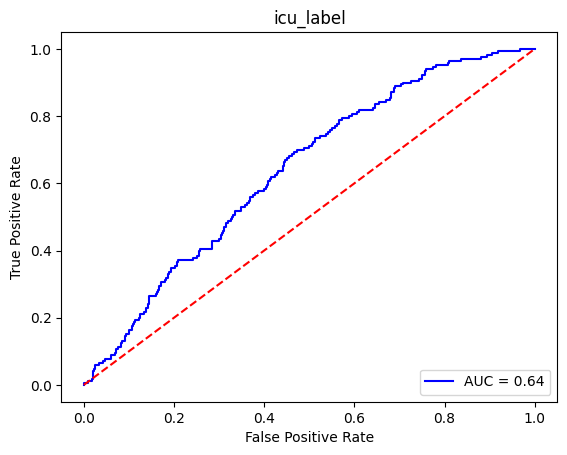

In [88]:
fpr, tpr, threshold = roc_curve(test['alive_24'], predictions[:,2])
roc_auc = auc(fpr, tpr)
plt.title('icu_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold_icu = threshold[optimal_idx]

# plt.show()
plt.savefig("image/icu_ROC.png")
# print(f"the optimal threshold is {optimal_threshold_icu}")

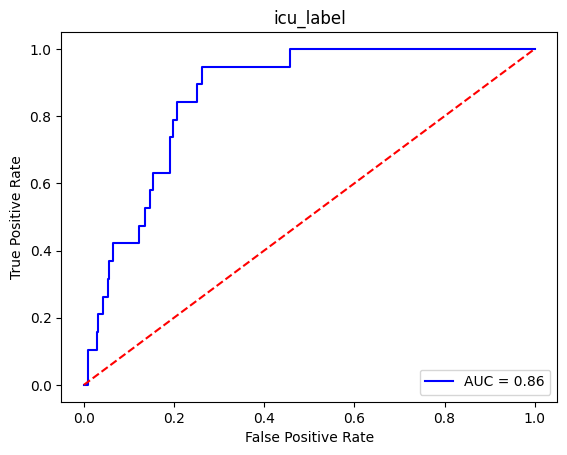

In [89]:
fpr, tpr, threshold = roc_curve(test['die_24'], predictions[:,3])
roc_auc = auc(fpr, tpr)
plt.title('icu_label')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold_icu = threshold[optimal_idx]

# plt.show()
plt.savefig("image/icu_ROC.png")
# print(f"the optimal threshold is {optimal_threshold_icu}")

## Feature Importance

[0.01090457 0.00455158 0.01459502 0.01630068 0.01043446 0.01868287
 0.01938873 0.01058372 0.01094825 0.03275177 0.00954641 0.
 0.0153649  0.00871455 0.03049542 0.01406979 0.         0.01344619
 0.         0.         0.01349081 0.00732462 0.01157908 0.
 0.00674569 0.00836117 0.         0.06177447 0.         0.00785672
 0.08607749 0.         0.00149529 0.01499865 0.         0.
 0.01469506 0.         0.01907508 0.         0.00916957 0.
 0.         0.         0.01957953 0.         0.         0.
 0.         0.         0.         0.         0.         0.02807339
 0.         0.00992183 0.01963909 0.00462582 0.00671823 0.00538122
 0.03063876 0.01412246 0.02559669 0.00665648 0.00841109 0.01053211
 0.00852141 0.01196107 0.0099691  0.01527819 0.0113823  0.01000602
 0.         0.         0.00989551 0.00752172 0.00864759 0.00881316
 0.00986531 0.01171477 0.00760661 0.00739172 0.00992007 0.0191927
 0.01442189 0.01370992 0.01095911 0.00939721 0.0133948  0.00832817
 0.01249643 0.01000139 0.         0.

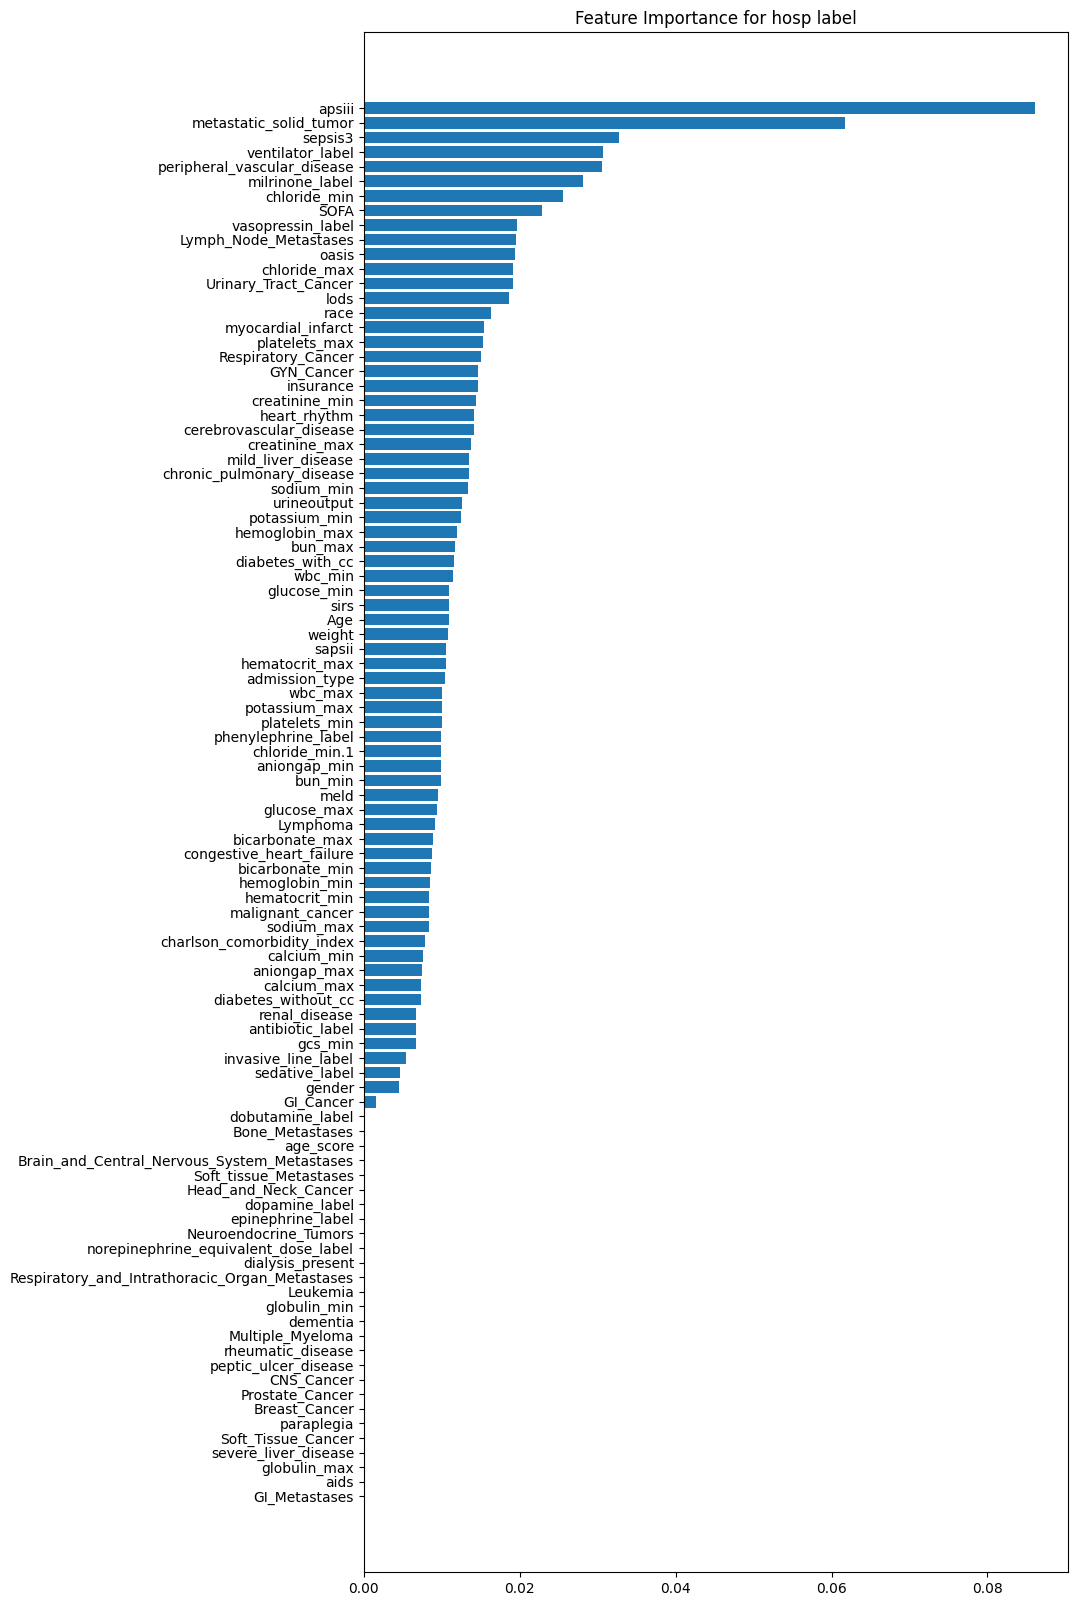

In [90]:
## hosp label feature importance
feature_importance = model.estimators_[0].feature_importances_
print(feature_importance)

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
# plt.figure(figsize=(10,6))
plt.title("Feature Importance for hosp label")
# plt.show()
plt.savefig("image/hosp_FI.png")

In [91]:
count1 = 0
count2 = 0
for index, row in resample_train.iterrows():
    if row['Soft_Tissue_Cancer'] == 1:
        count1 += 1
        
    else:
        count2 += 1
        
print(count1)
print(count2)
    

15
1749


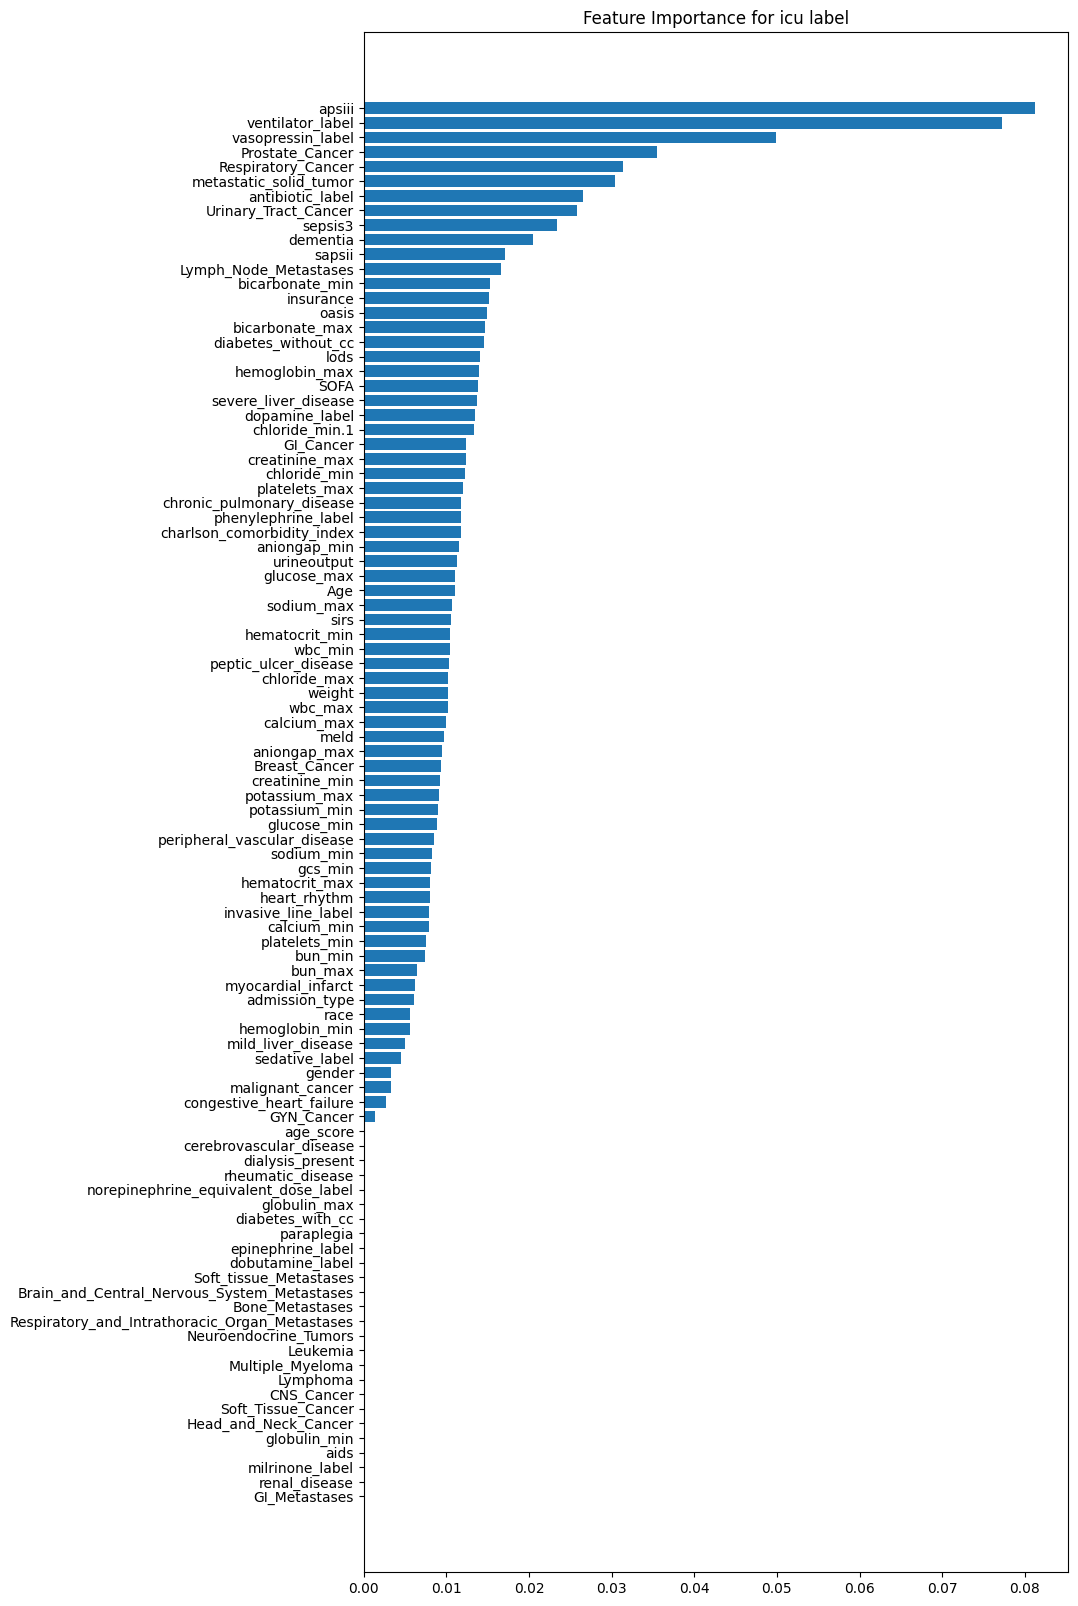

In [92]:
## hosp label feature importance
feature_importance = model.estimators_[1].feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
# plt.figure(figsize=(10,6))
plt.title("Feature Importance for icu label")
# plt.show()
plt.savefig("image/icu_FI.png")

## Confusion Matrix

In [93]:
descicion_icu = []
descicion_hosp = []
for i in predictions[:, 1]:
    if(i > optimal_threshold_icu):
        descicion_icu.append(1)
    else:
        descicion_icu.append(0)

descicion_hosp = []
for i in predictions[:, 0]:
    if(i > optimal_threshold_hosp):
        descicion_hosp.append(1)
    else:
        descicion_hosp.append(0)

label_hosp confusion matrix
[[381 136]
 [ 18  93]]
accuracy 0.7547770700636943
precision 0.40611353711790393
recall 0.8378378378378378
specificity 0.7369439071566731
f1 0.5470588235294118


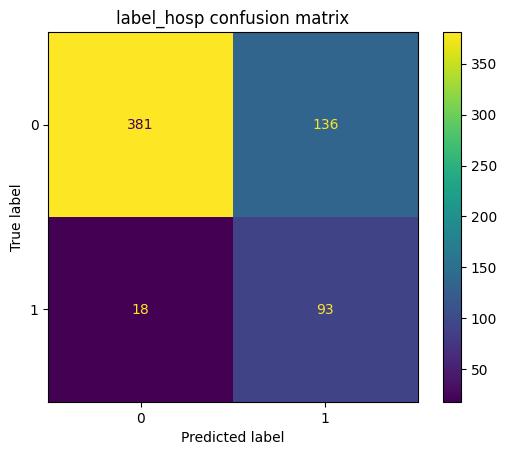

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay
title = "label_hosp confusion matrix"
disp = ConfusionMatrixDisplay.from_predictions(y_true = test_label_hosp, y_pred=descicion_hosp)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

print(f"accuracy {accuracy_score(test_label_hosp, descicion_hosp)}")
print(f"precision {precision_score(test_label_hosp, descicion_hosp)}")
print(f"recall {recall_score(test_label_hosp, descicion_hosp)}")
print(f"specificity {specificity_score(test_label_hosp, descicion_hosp)}")
print(f"f1 {f1_score(test_label_hosp, descicion_hosp)}")
# plt.show()
plt.savefig("image/hosp_CM.png")

label_icu confusion matrix
[[427 120]
 [ 16  65]]
accuracy 0.7834394904458599
precision 0.35135135135135137
recall 0.8024691358024691
specificity 0.7806215722120659
f1 0.4887218045112783


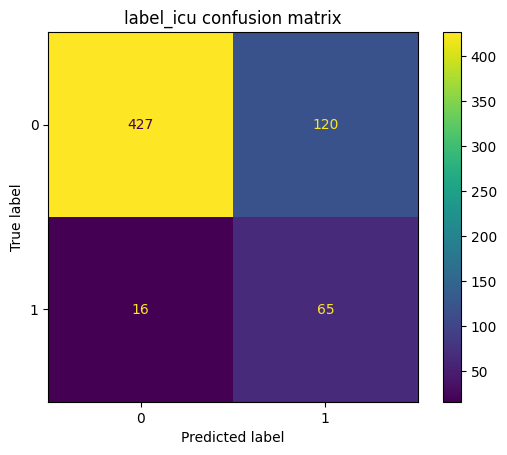

In [95]:
title = "label_icu confusion matrix"
disp = ConfusionMatrixDisplay.from_predictions(y_true = test_label_icu, y_pred=descicion_icu)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)
print(f"accuracy {accuracy_score(test_label_icu, descicion_icu)}")
print(f"precision {precision_score(test_label_icu, descicion_icu)}")
print(f"recall {recall_score(test_label_icu, descicion_icu)}")
print(f"specificity {specificity_score(test_label_icu, descicion_icu)}")
print(f"f1 {f1_score(test_label_icu, descicion_icu)}")
# plt.show()
plt.savefig("image/ICU_CM.png")

In [96]:
descicion_die = []
descicion_alive = []
for i in predictions[:, 2]:
    if(i > optimal_threshold_alive):
        descicion_alive.append(1)
    else:
        descicion_alive.append(0)

for i in predictions[:, 3]:
    if(i > optimal_threshold_die):
        descicion_die.append(1)
    else:
        descicion_die.append(0)

alive_24 confusion matrix
[[176 282]
 [ 31 139]]
accuracy 0.5015923566878981
precision 0.33016627078384797
recall 0.8176470588235294
specificity 0.38427947598253276
f1 0.4703891708967851


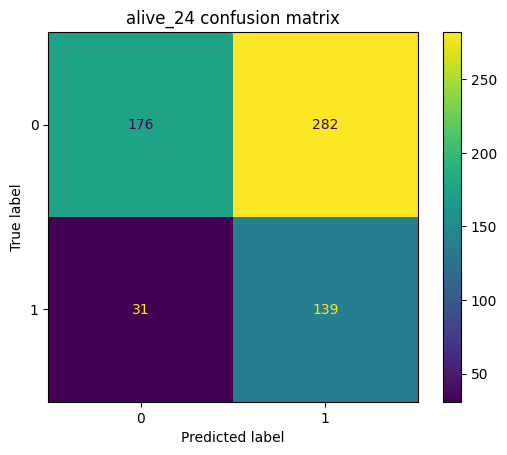

In [97]:
title = "alive_24 confusion matrix"
disp = ConfusionMatrixDisplay.from_predictions(y_true = test['alive_24'], y_pred=descicion_alive)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)
print(f"accuracy {accuracy_score(test['alive_24'],descicion_alive)}")
print(f"precision {precision_score(test['alive_24'],descicion_alive)}")
print(f"recall {recall_score(test['alive_24'],descicion_alive)}")
print(f"specificity {specificity_score(test['alive_24'],descicion_alive)}")
print(f"f1 {f1_score(test['alive_24'],descicion_alive)}")
# plt.show()
plt.savefig("image/alive_CM.png")

die_24 confusion matrix
[[450 159]
 [  2  17]]
accuracy 0.7436305732484076
precision 0.09659090909090909
recall 0.8947368421052632
specificity 0.7389162561576355
f1 0.17435897435897435


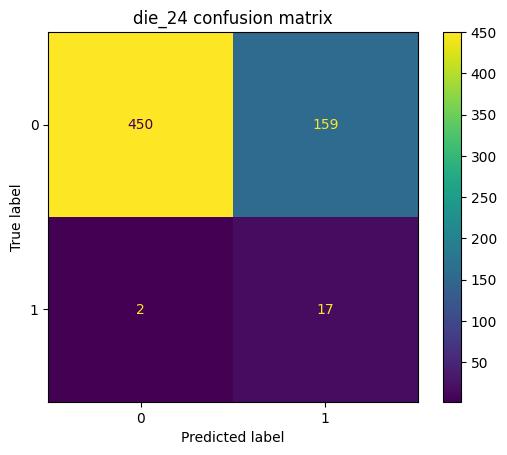

In [98]:
title = "die_24 confusion matrix"
disp = ConfusionMatrixDisplay.from_predictions(y_true = test['die_24'], y_pred=descicion_die)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)
print(f"accuracy {accuracy_score(test['die_24'],descicion_die)}")
print(f"precision {precision_score(test['die_24'],descicion_die)}")
print(f"recall {recall_score(test['die_24'],descicion_die)}")
print(f"specificity {specificity_score(test['die_24'],descicion_die)}")
print(f"f1 {f1_score(test['die_24'],descicion_die)}")
# plt.show()
plt.savefig("image/die_CM.png")

## Calibration plot

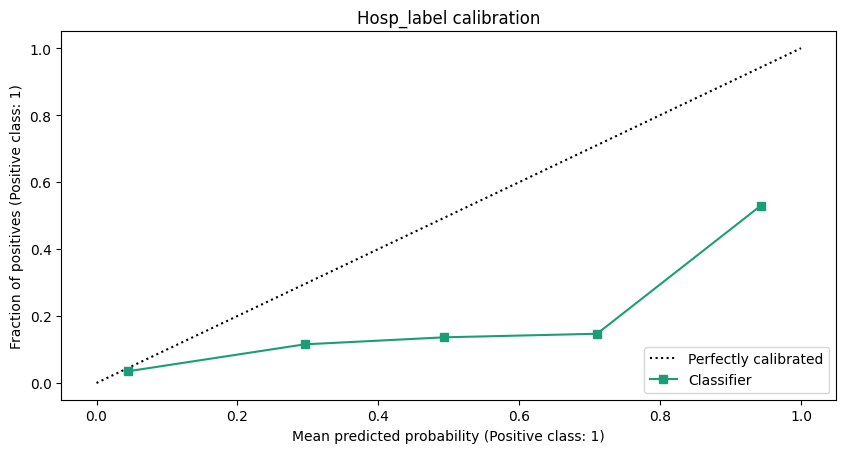

In [99]:
#hosp_cal = CalibratedClassifierCV(estimator=model.estimators_[0], method='sigmoid', cv=5)
#y_score_xgb = cross_val_predict(estimator=model.estimators_[0], X=test_features, y=test_label_hosp + test_label_icu, method='predict_proba', cv=5)
from sklearn.calibration import calibration_curve, CalibrationDisplay
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

# display = CalibrationDisplay.from_estimator(
#     model.estimators_[0],
#     test_features,
#     test_label_hosp,
#     n_bins=10,
#     name="xgboost",
#     ax=ax_calibration_curve,
#     color=colors(i),
# )
# y_prob = model.estimators_[0].predict_proba(test_features)[:, 1]
display = CalibrationDisplay.from_predictions(test_label_hosp, predictions[:,0], n_bins=5, ax=ax_calibration_curve, color=colors(0))

calibration_displays["xgboost"] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Hosp_label calibration")
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Hosp_label calibration")
plt.savefig("image/hosp_cal.png")

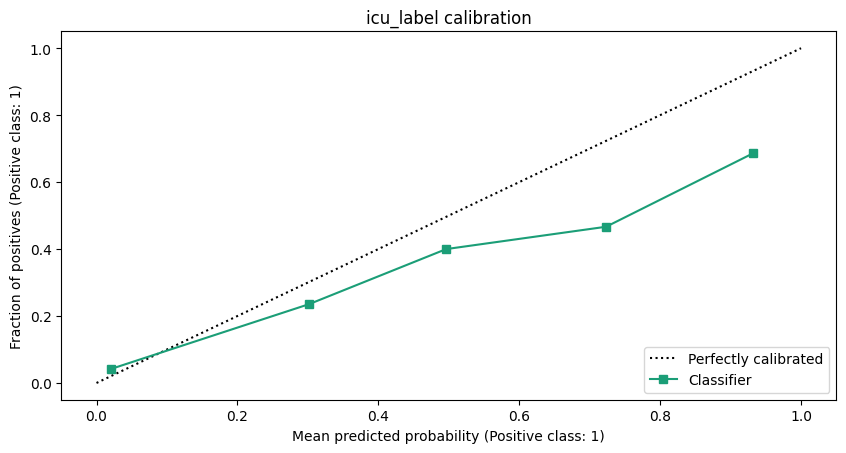

In [100]:
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = CalibrationDisplay.from_predictions(test_label_icu, predictions[:,1], n_bins=5, ax=ax_calibration_curve, color=colors(0))

calibration_displays["xgboost"] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("icu_label calibration")
ax_calibration_curve.grid()
ax_calibration_curve.set_title("icu_label calibration")
plt.savefig("image/icu_cal.png")

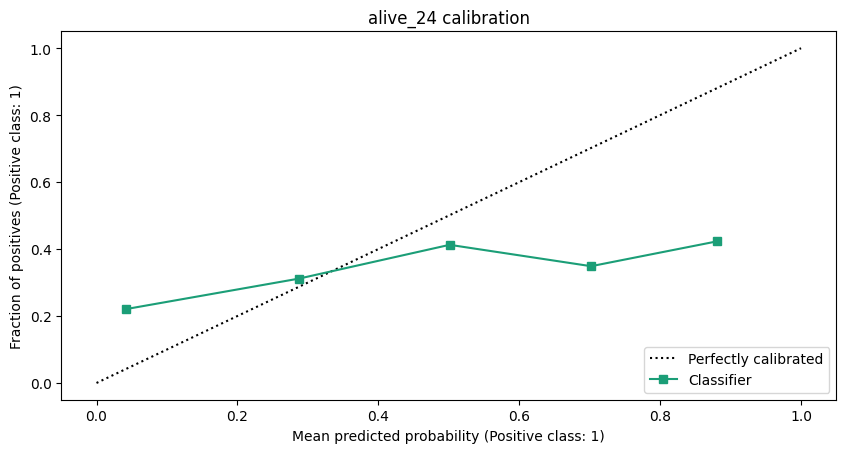

In [101]:
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = CalibrationDisplay.from_predictions(test["alive_24"], predictions[:,2], n_bins=5, ax=ax_calibration_curve, color=colors(0))

calibration_displays["xgboost"] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("alive_24 calibration")
ax_calibration_curve.grid()
ax_calibration_curve.set_title("alive_24 calibration")
plt.savefig("image/alive_cal.png")

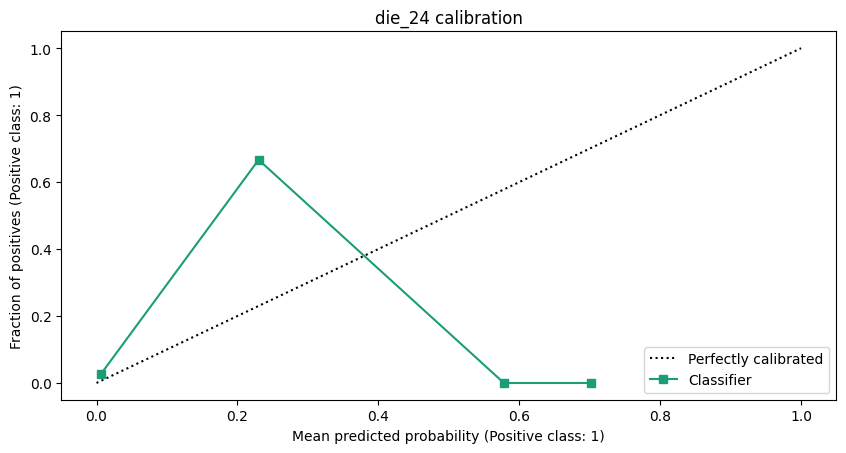

In [102]:
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

display = CalibrationDisplay.from_predictions(test["die_24"], predictions[:,3], n_bins=5, ax=ax_calibration_curve, color=colors(0))

calibration_displays["xgboost"] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("die_24 calibration")
ax_calibration_curve.grid()
ax_calibration_curve.set_title("die_24 calibration")
plt.savefig("image/die_cal.png")

## Fairness

In [103]:
def get_df_based_on_label(df, column, label):
    include = []
    
    for index, row in df.iterrows():
        if row[column] in label:
            include.append(row)

    return pd.DataFrame(include, columns = df.columns)

In [104]:
race = [[1,2,5, 7], [3],[4],[6],[8]]

for r in race:
    new_test_df = get_df_based_on_label(test, "race", r)
    p = model.predict(new_test_df.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24']))
    print(r)
    
    try:
        accuracy_hosp = roc_auc_score(new_test_df["label_hosp"], p[:, 0])

        print(f"AUC_hosp = {accuracy_hosp}")

    except:
        print("nan")

    try:
        accuracy_icu = roc_auc_score(new_test_df["label_icu"], p[:, 1])
    
        print(f"AUC_icu = {accuracy_icu}")

    except:
        print("nan")

    try:
        accuracy_alive = roc_auc_score(new_test_df["alive_24"], p[:, 2])
    
        print(f"AUC_alive = {accuracy_alive}")

    except:
        print("nan")

    try:
        accuracy_die = roc_auc_score(new_test_df["die_24"], p[:, 3])
    
        print(f"AUC_die = {accuracy_die}")

    except:
        print("nan")
        # print(new_test_df)
    print("=====================================================")




[1, 2, 5, 7]
AUC_hosp = 0.9244444444444444
AUC_icu = 0.9485294117647058
AUC_alive = 0.5777777777777777
nan
[3]
AUC_hosp = 0.9266666666666666
AUC_icu = 0.7142857142857143
AUC_alive = 0.6466666666666666
AUC_die = 0.9666666666666667
[4]
AUC_hosp = 0.8575113461977993
AUC_icu = 0.8999203387698629
AUC_alive = 0.6557441866211975
AUC_die = 0.8867545871559634
[6]
AUC_hosp = 0.9166666666666665
AUC_icu = 0.9074074074074074
AUC_alive = 0.6083333333333334
AUC_die = 0.75
[8]
AUC_hosp = 0.7857142857142857
AUC_icu = 0.8695652173913043
AUC_alive = 0.6493506493506493
AUC_die = 0.33333333333333337


In [105]:
gender = [[0], [1]]

for g in gender:
    new_test_df = get_df_based_on_label(test, "gender", g)

    p = model.predict(new_test_df.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24']))
    print(g)
    
    try:
        accuracy_hosp = roc_auc_score(new_test_df["label_hosp"], p[:, 0])

        print(f"AUC_hosp = {accuracy_hosp}")

    except:
        print("nan")

    try:
        accuracy_icu = roc_auc_score(new_test_df["label_icu"], p[:, 1])
    
        print(f"AUC_icu = {accuracy_icu}")

    except:
        print("nan")

    try:
        accuracy_alive = roc_auc_score(new_test_df["alive_24"], p[:, 2])
    
        print(f"AUC_alive = {accuracy_alive}")

    except:
        print("nan")

    try:
        accuracy_die = roc_auc_score(new_test_df["die_24"], p[:, 3])
    
        print(f"AUC_die = {accuracy_die}")

    except:
        print("nan")
        # print(new_test_df)

    print("=====================================================")



    

[0]
AUC_hosp = 0.9075773272162202
AUC_icu = 0.9263894000736106
AUC_alive = 0.6168822932521563
AUC_die = 0.8406198118428334
[1]
AUC_hosp = 0.820223226149349
AUC_icu = 0.8714414414414415
AUC_alive = 0.6567329860814618
AUC_die = 0.8952668680765357


In [106]:
insurance = [[1], [2],[3],[4], [5], [6]]

for i in insurance:
    new_test_df = get_df_based_on_label(test, "insurance", i)
    # print(new_test_df)
    if new_test_df.empty == True:
        print("nan\nnan (empty)")
        print("=====================================================")
        continue
    p = model.predict(new_test_df.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24']))
    print(i)
    
    try:
        accuracy_hosp = roc_auc_score(new_test_df["label_hosp"], p[:, 0])

        print(f"AUC_hosp = {accuracy_hosp}")

    except:
        print("nan")

    try:
        accuracy_icu = roc_auc_score(new_test_df["label_icu"], p[:, 1])
    
        print(f"AUC_icu = {accuracy_icu}")

    except:
        print("nan")

    try:
        accuracy_alive = roc_auc_score(new_test_df["alive_24"], p[:, 2])
    
        print(f"AUC_alive = {accuracy_alive}")

    except:
        print("nan")

    try:
        accuracy_die = roc_auc_score(new_test_df["die_24"], p[:, 3])
    
        print(f"AUC_die = {accuracy_die}")

    except:
        print("nan")
        # print(new_test_df)

    print("=====================================================")


nan
nan (empty)
[2]
AUC_hosp = 0.8588235294117648
AUC_icu = 0.8339768339768339
AUC_alive = 0.6357142857142857
AUC_die = 0.7738095238095238
[3]
AUC_hosp = 0.837280701754386
AUC_icu = 0.9253112033195021
AUC_alive = 0.6453447050461976
AUC_die = 0.8930555555555556
nan
nan (empty)
nan
nan (empty)
[6]
AUC_hosp = 0.9028066128412149
AUC_icu = 0.9007334472018488
AUC_alive = 0.6322422349857805
AUC_die = 0.88327721661055


## Inference

In [107]:
final_prediction = model.predict(data.drop(columns = ['label_hosp', 'label_icu', 'hosp_timestep_back', 'icu_timestep_back', 'stay_id', 'alive_24', 'die_24']))

In [108]:
final_prediction_data = {'stay_id': data['stay_id'], 'label_hosp': final_prediction[:,0], 'label_icu': final_prediction[:,1], 'alive_24': final_prediction[:,2], 'die_24': final_prediction[:,3]}
final_prediction_df = pd.DataFrame(final_prediction_data)
final_prediction_df

,stay_id,label_hosp,label_icu,alive_24,die_24
0,37603522,0.031927,0.002694,0.825461,0.000122
1,39139520,0.003228,0.000036,0.048483,0.000016
2,36195775,0.094661,0.101845,0.003469,0.000102
3,33268937,0.964005,0.010830,0.015198,0.000150
4,39319468,0.985941,0.028007,0.951599,0.000185
...,...,...,...,...,...
6278,34150098,0.973364,0.004987,0.002837,0.003131
6279,39015846,0.992243,0.984507,0.000437,0.002352
6280,37950364,0.007298,0.000883,0.624683,0.000878
6281,36733811,0.000897,0.000169,0.962290,0.000051


In [109]:
final_prediction_df.to_csv('xg_boost_pred.csv', index = False)